In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = True
params.d2d.ini_att = 0.01
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in Oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro 
params.platforms.fare = float(1.2)# float(1.20) #euro/km #http://taxihowmuch.com/
params.platforms.min_fare = float(4) # euro #http://taxihowmuch.com/
params.d2d.fuel_cost = 0.25 #euro/km #https://help.ubercarshare.com/hc/en-gb/articles/360022882131-Choosing-your-car-s-distance-rate  
params.platforms.comm_rate = float(0.20) # float(0.20) for baseline
params.platforms.discount = float(0.0) 
params.platforms.daily_marketing = False
params.platforms.incentive = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 
params.d2d.m = 7
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1

# We would like to have the same inequality for VoT and RW: We can set a proportional standard deviation relative to the mean for each distribution. 
# This means that the standard deviation will be a fraction of the mean for each variable. By doing this, the spread of the distributions will be 
# proportional to their respective means, resulting in a consistent level of inequality.
params.proportional_std = 0.1 # proportional standard deviation [0.1, 0.2, 0.3] for both VoT & RW distributions
params.f_stop_crit = False
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 2500 # simulation might terminate earlier eif we set params.f_stop_crit=True
params.simTime = 4
params.d2d.res_wage = params.simTime*11.16 

In [6]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
11-12-23 09:47:04-WARNING-Setting up 4h simulation at 2023-12-11 07:45:43 for 100 vehicles and 1000 passengers in Amsterdam, Netherlands
Day =  0
11-12-23 09:47:10-WARNING-simulation time 1.5 s
nP =  0    nV =  0
Day =  1
11-12-23 09:47:16-WARNING-simulation time 1.8 s
nP =  5    nV =  1


In [ ]:
# Figures:
# 1. aggregated market share for supply and demand indicating for populations (equal, moderately equal, ...)
# 2. aggregated KPIs like average waiting time, average income  
# 2. VoT/RW vs number of days worked/hailed
# 3. individual experience of randomly selected agents (one per each class as representative)

In [47]:
# Save CSV

params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

dis_df_s = pd.DataFrame()
dis_df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    df_d.at[d, 'EXPERIENCE_U'] = pax_exp.EXPERIENCE_U.mean()
    df_d.at[d, 'WOM_U'] = pax_exp.WOM_U.mean()
    df_d.at[d, 'MARKETING_U'] = pax_exp.MARKETING_U.mean()
    df_d.at[d, 'OUT'] = pax_exp.OUT.value_counts().get(False, 0)
    
    ind_d = sim.res[d].pax_exp[['nDAYS_HAILED', 'ACTUAL_WT', 'EXPERIENCE_U', 'MARKETING_U', 'WOM_U', 'VoT']]
    ind_d['day'] = d
    dis_df_d = pd.concat([dis_df_d, ind_d])
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
#---------------------------------------------------------------------------------
    
    veh_exp = sim.res[d].veh_exp
    df_s.at[d, 'EXPERIENCE_U'] = veh_exp.EXPERIENCE_U.mean()
    df_s.at[d, 'WOM_U'] = veh_exp.WOM_U.mean()
    df_s.at[d, 'MARKETING_U'] = veh_exp.MARKETING_U.mean()
    df_s.at[d, 'OUT'] = veh_exp.OUT.value_counts().get(False, 0)
    
    ind_s = sim.res[d].veh_exp[['nDAYS_WORKED', 'ACTUAL_INC', 'EXPERIENCE_U', 'MARKETING_U', 'WOM_U', 'res_wage']]
    ind_s['day'] = d
    dis_df_s = pd.concat([dis_df_s, ind_s])
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()

df_d.fillna(0, inplace=True)
df_s.fillna(0, inplace=True)

df_d.to_csv('data/Heterogeneity/aggregated_demand_pp_std_{}.csv'.format(params.proportional_std))
df_s.to_csv('data/Heterogeneity/aggregated_supply_pp_std_{}.csv'.format(params.proportional_std))

dis_df_d.to_csv('data/Heterogeneity/dis_aggr_demand_pp_std_{}.csv'.format(params.proportional_std))
dis_df_s.to_csv('data/Heterogeneity/dis_aggr_supply_pp_std_{}.csv'.format(params.proportional_std))

(array([0.00052914, 0.        , 0.        , 0.00105828, 0.00423312,
        0.00370398, 0.00582055, 0.00899539, 0.01481593, 0.02328218,
        0.03069015, 0.04021468, 0.04973921, 0.0444478 , 0.04286038,
        0.03968554, 0.05079749, 0.04286038, 0.03968554, 0.02698617,
        0.02169476, 0.01111195, 0.00740797, 0.01005367, 0.00423312,
        0.00105828, 0.0026457 , 0.        , 0.        , 0.00052914]),
 array([12.04512474, 13.93498191, 15.82483907, 17.71469624, 19.60455341,
        21.49441058, 23.38426774, 25.27412491, 27.16398208, 29.05383925,
        30.94369641, 32.83355358, 34.72341075, 36.61326792, 38.50312508,
        40.39298225, 42.28283942, 44.17269658, 46.06255375, 47.95241092,
        49.84226809, 51.73212525, 53.62198242, 55.51183959, 57.40169676,
        59.29155392, 61.18141109, 63.07126826, 64.96112543, 66.85098259,
        68.74083976]),
 <BarContainer object of 30 artists>)

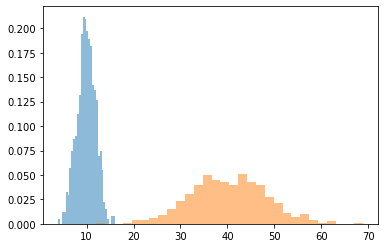

In [9]:
# Set the means
mean_a = 10
mean_b = 40

# Set a common proportional standard deviation for both distributions
proportional_std_dev_a = 0.2  # 20% of the mean
proportional_std_dev_b = 0.2  # 20% of the mean

# Generate random samples from the normal distributions
samples_a = np.random.normal(mean_a, mean_a * proportional_std_dev_a, 1000)
samples_b = np.random.normal(mean_b, mean_b * proportional_std_dev_b, 1000)

# Plot the histograms
plt.hist(samples_a, bins=30, density=True, alpha=0.5, label='Variable A')
plt.hist(samples_b, bins=30, density=True, alpha=0.5, label='Variable B')


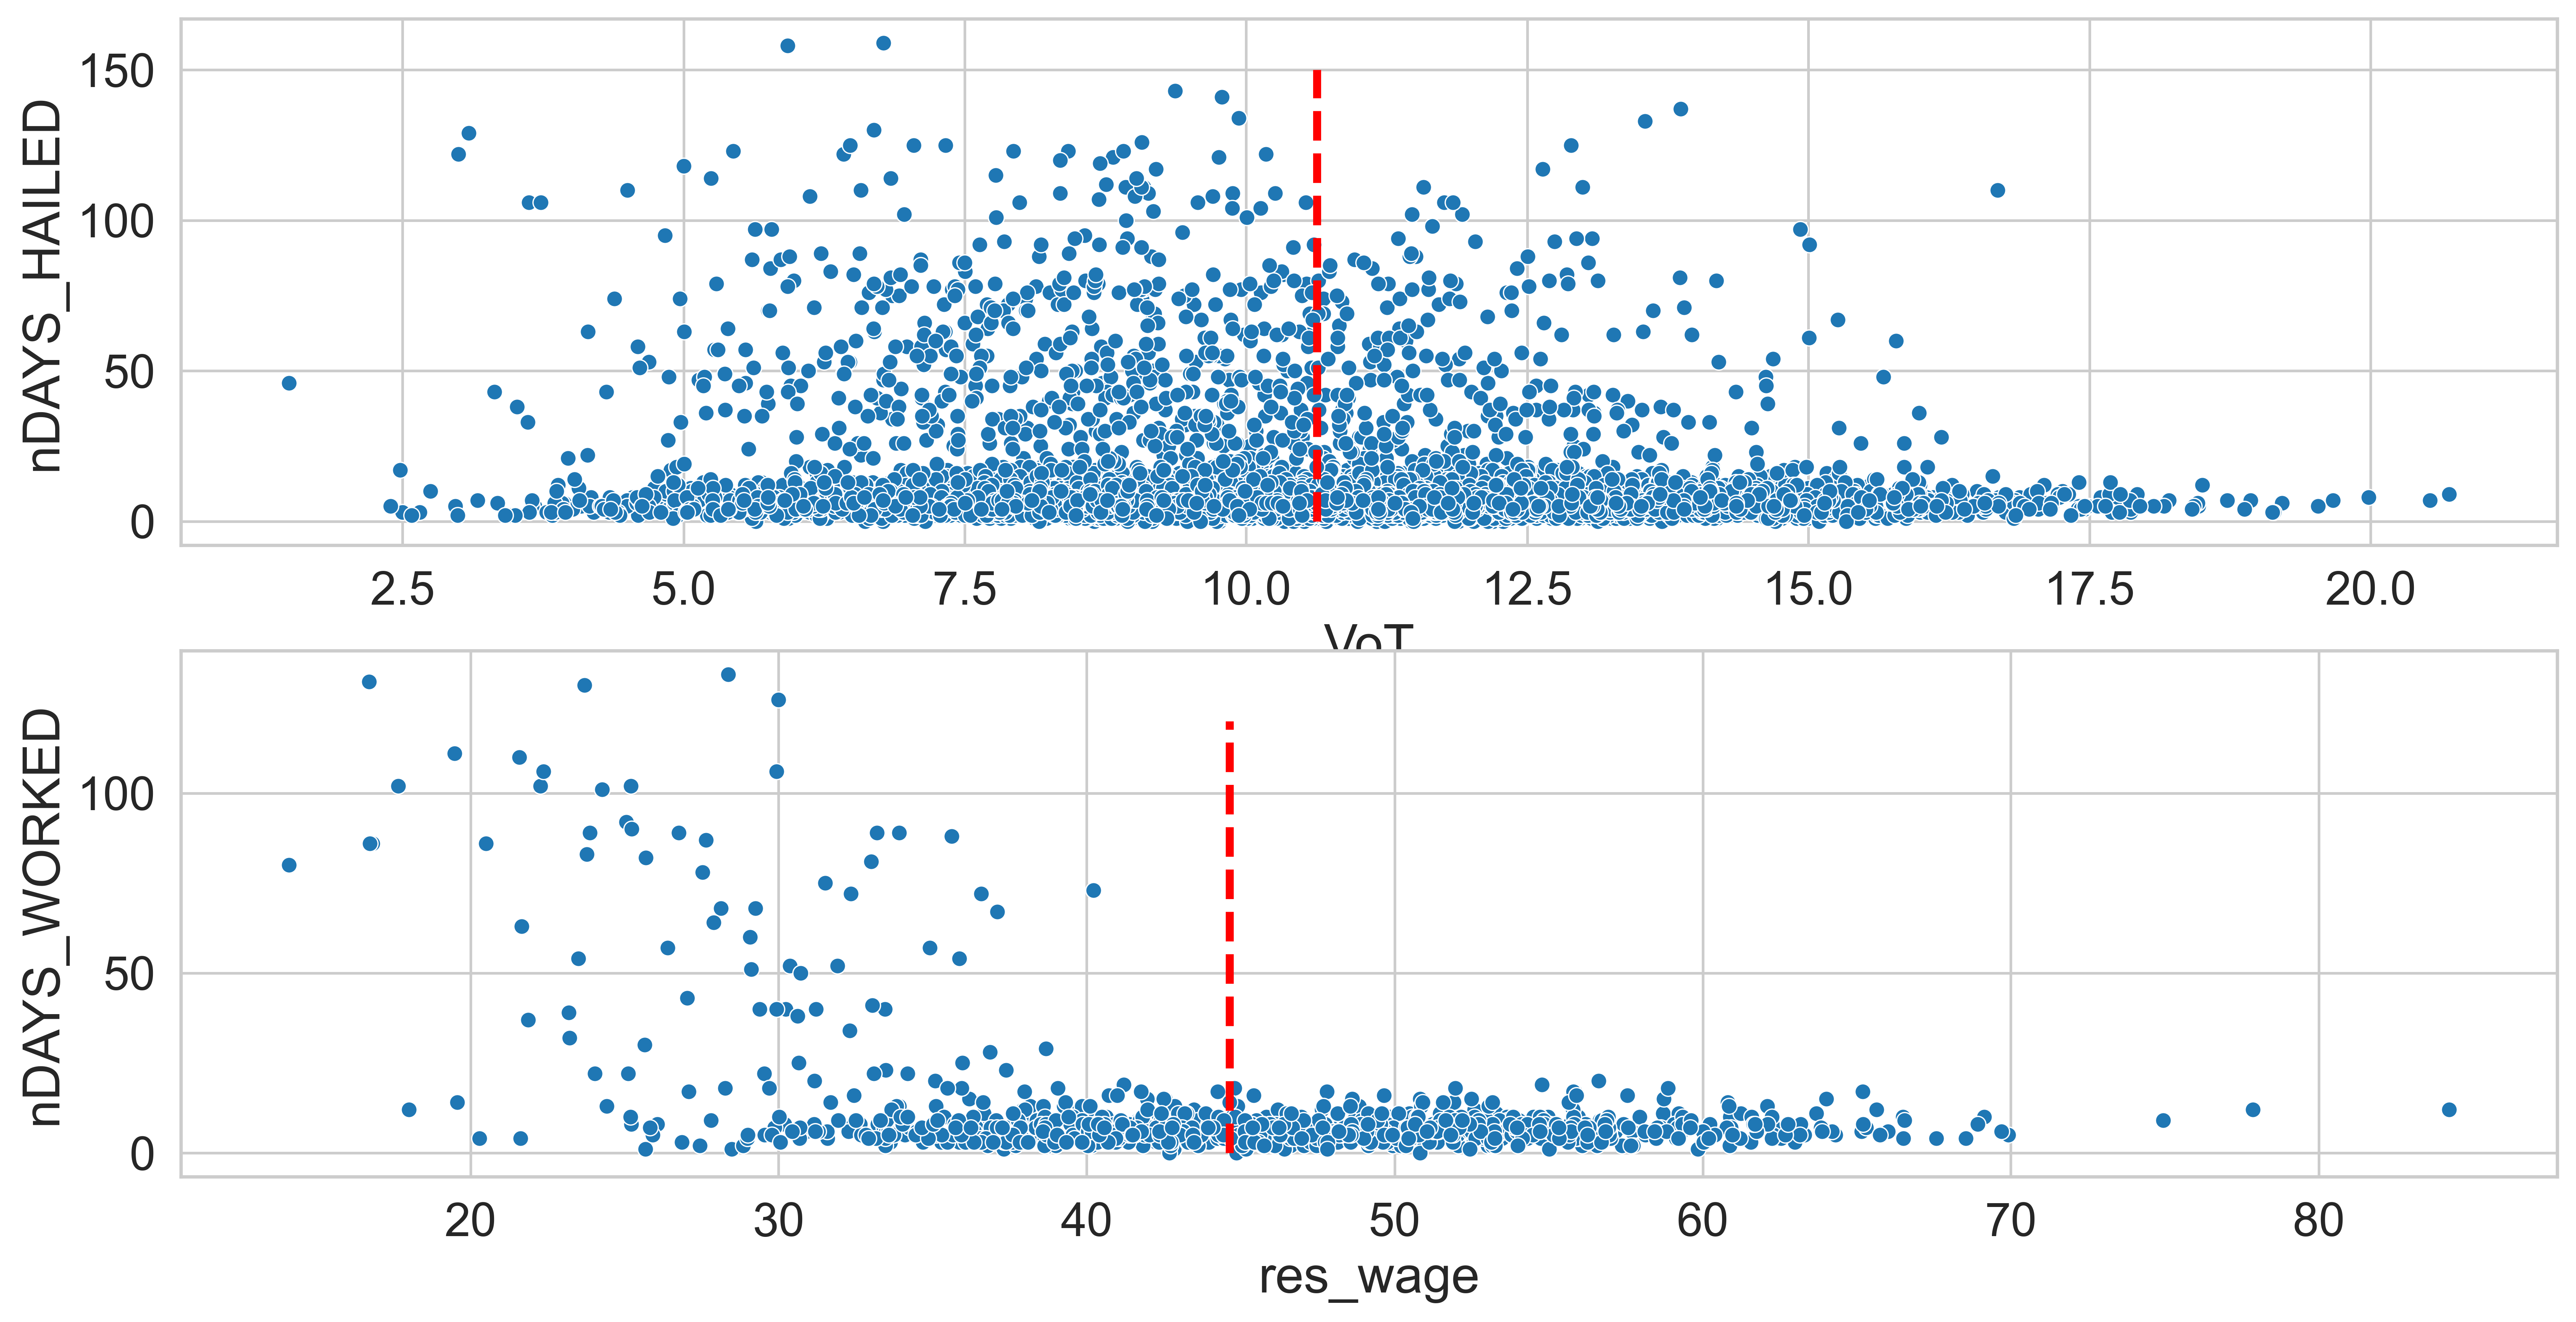

In [43]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))


sns.scatterplot(x=sim.res[0].pax_exp.VoT, y=sim.res[199].pax_exp.nDAYS_HAILED, ax=ax[0])
ax[0].vlines([params.VoT], 0, 150, linestyles='dashed', colors='red', lw=3)

sns.scatterplot(x=sim.res[0].veh_exp.res_wage, y=sim.res[199].veh_exp.nDAYS_WORKED, ax=ax[1])
ax[1].vlines([params.d2d.res_wage], 0, 120, linestyles='dashed', colors='red', lw=3)

plt.tight_layout()

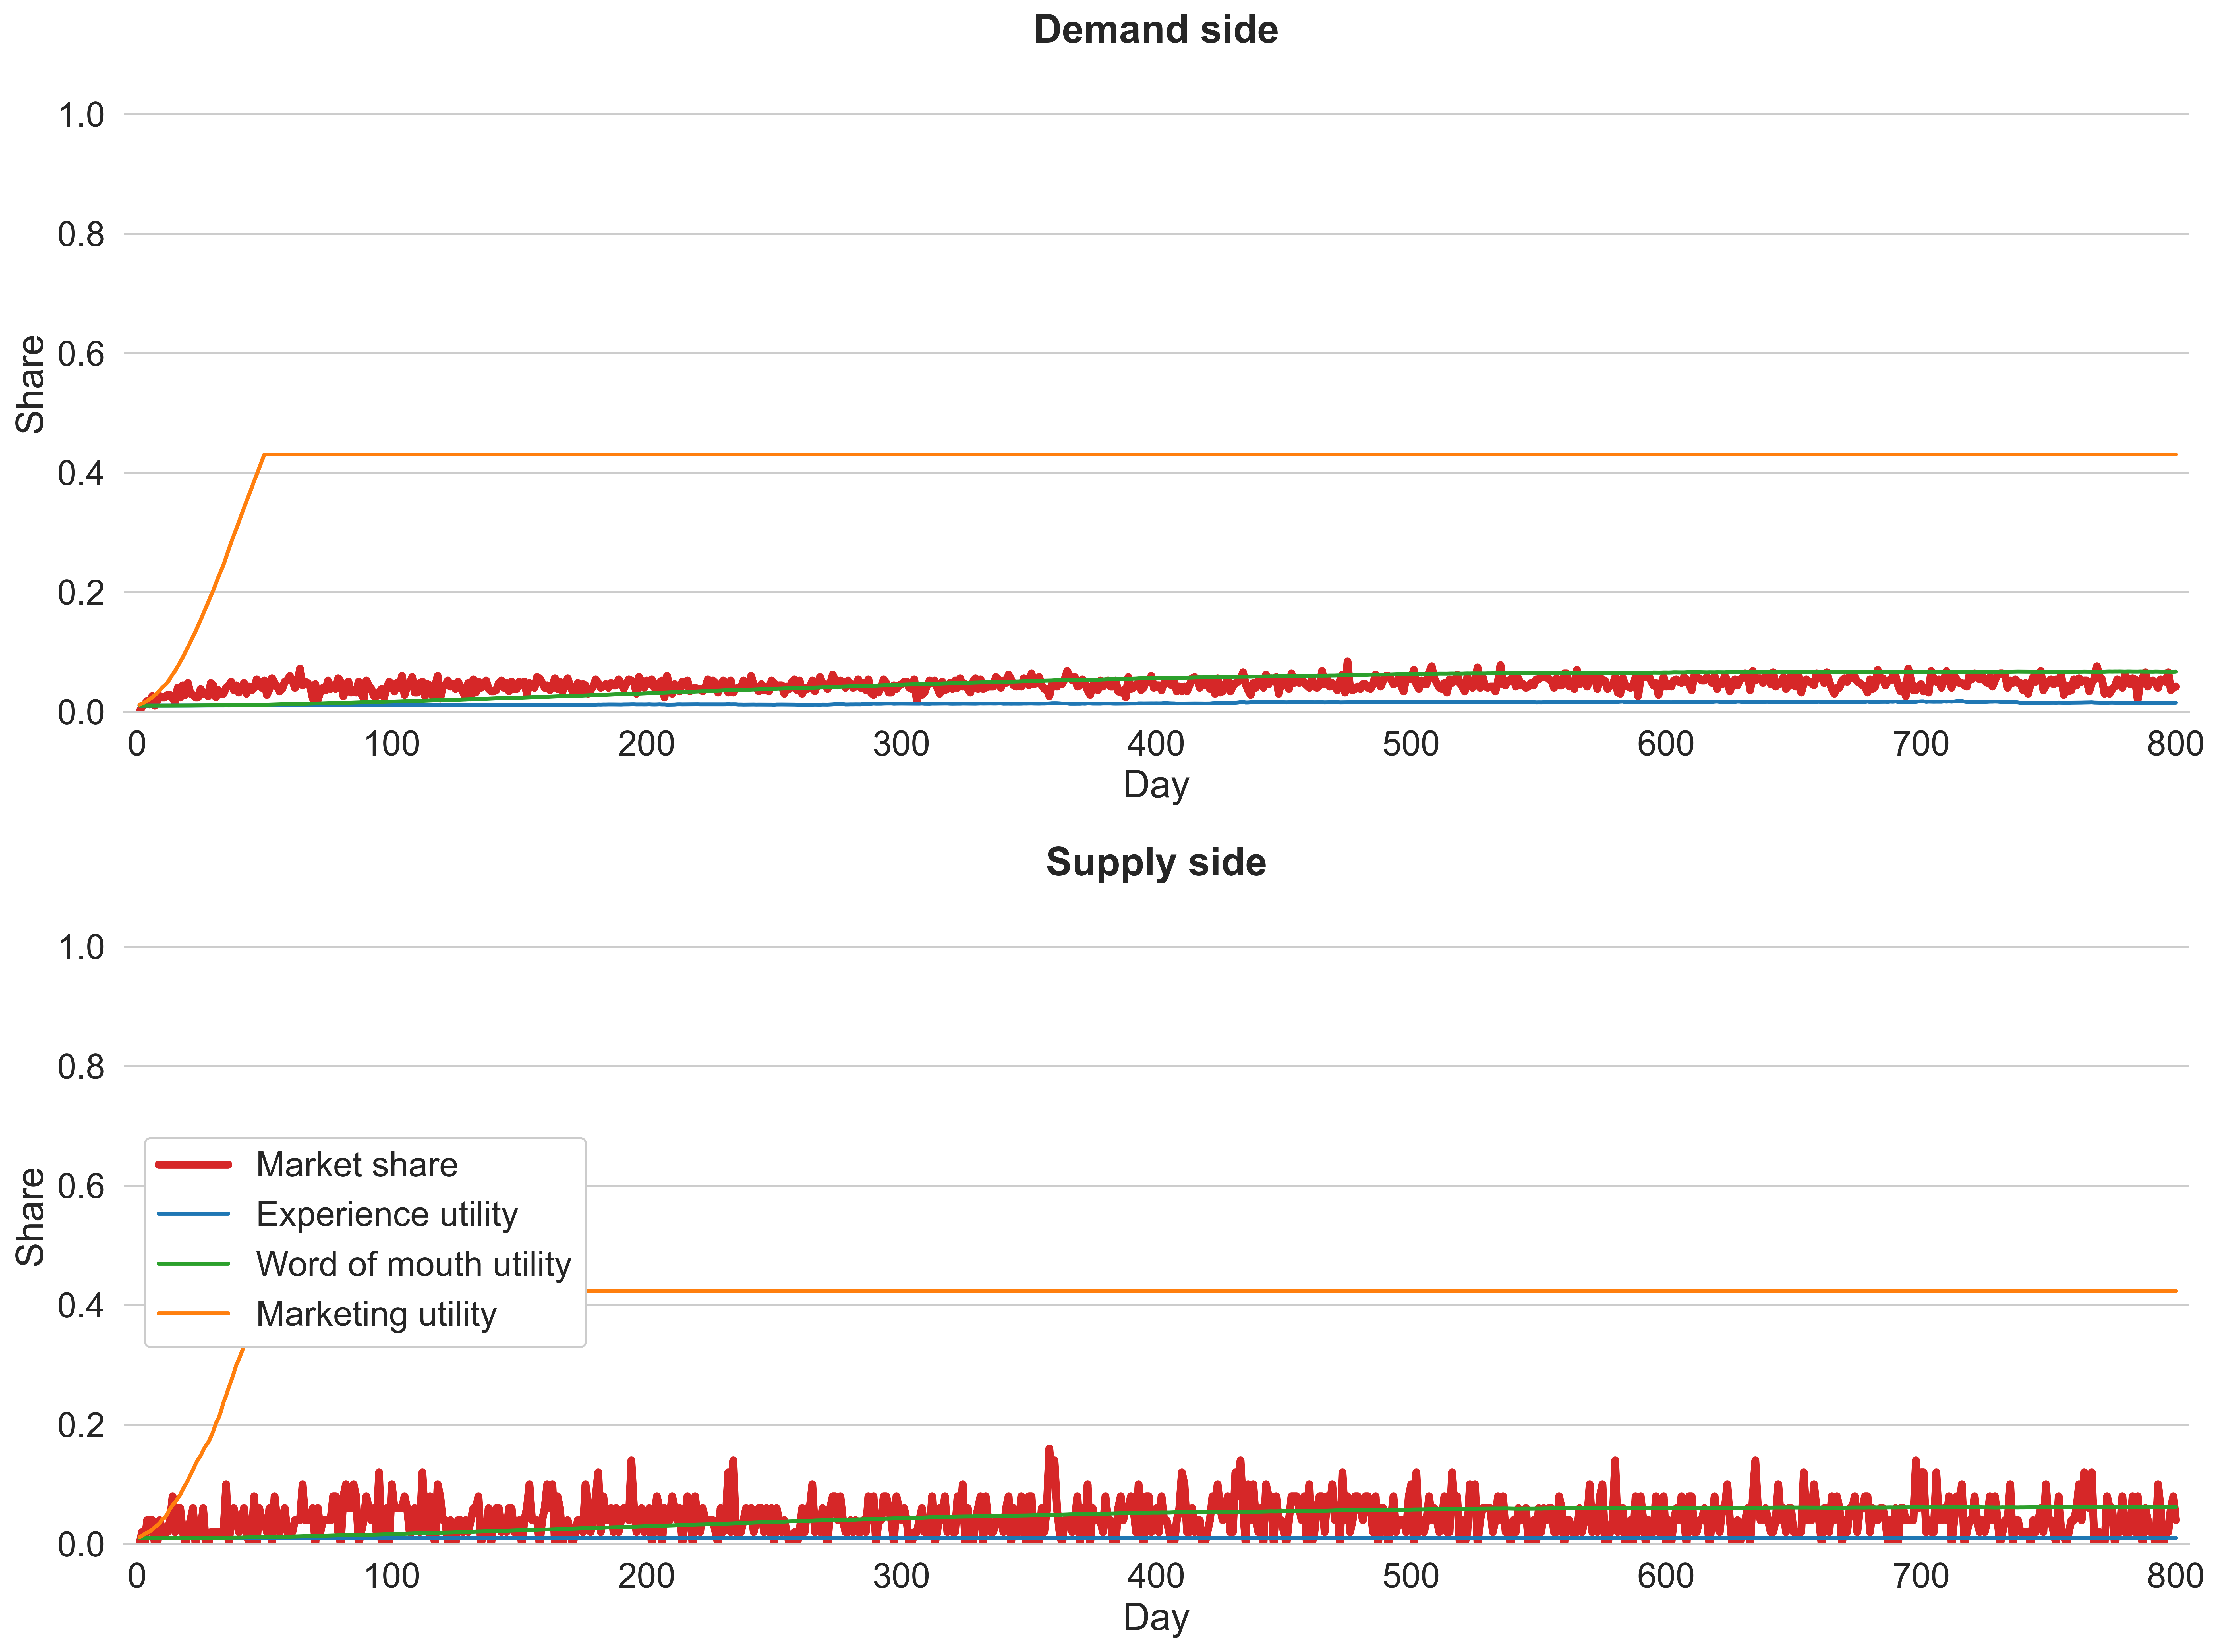

In [8]:
# np 10000, nv 1000, fare 1.2 euro, simtime 4, .d2d.m = 7

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
# params.nD=2000
# params.nP=10000
# params.nV=100
for row in range(0,2):
    
    if row==0:
        df=df_d; n=params.nP; label='Demand side'
    elif row==1:
        df = df_s; n = params.nV; label='Supply side'
        
    lx = [i for i in range(1,params.nD+1)]
    sns.lineplot(x=lx, y=df.OUT/n, label = 'Market share', color='C3', lw=4, ax=ax[row])
    sns.lineplot(x=lx, y=df.EXPERIENCE_U, label = 'Experience utility', color='C0', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.WOM_U, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.MARKETING_U, label = 'Marketing utility', color='C1', lw=2, ax=ax[row])

    ax[row].grid(axis='x')
    ax[row].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,params.nD+5))
    ax[row].set_title(label,fontweight='bold', loc='center',fontsize=20)

ax[1].legend(frameon=True,framealpha=1, loc=(0.01,0.3))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
# ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
# for i in range(0,6):
#     value = ['I','II','III','IV','V','VI']
#     coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
#     ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1x.png')

In [ ]:
def smooth(y,w=17,o=1,d=2):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

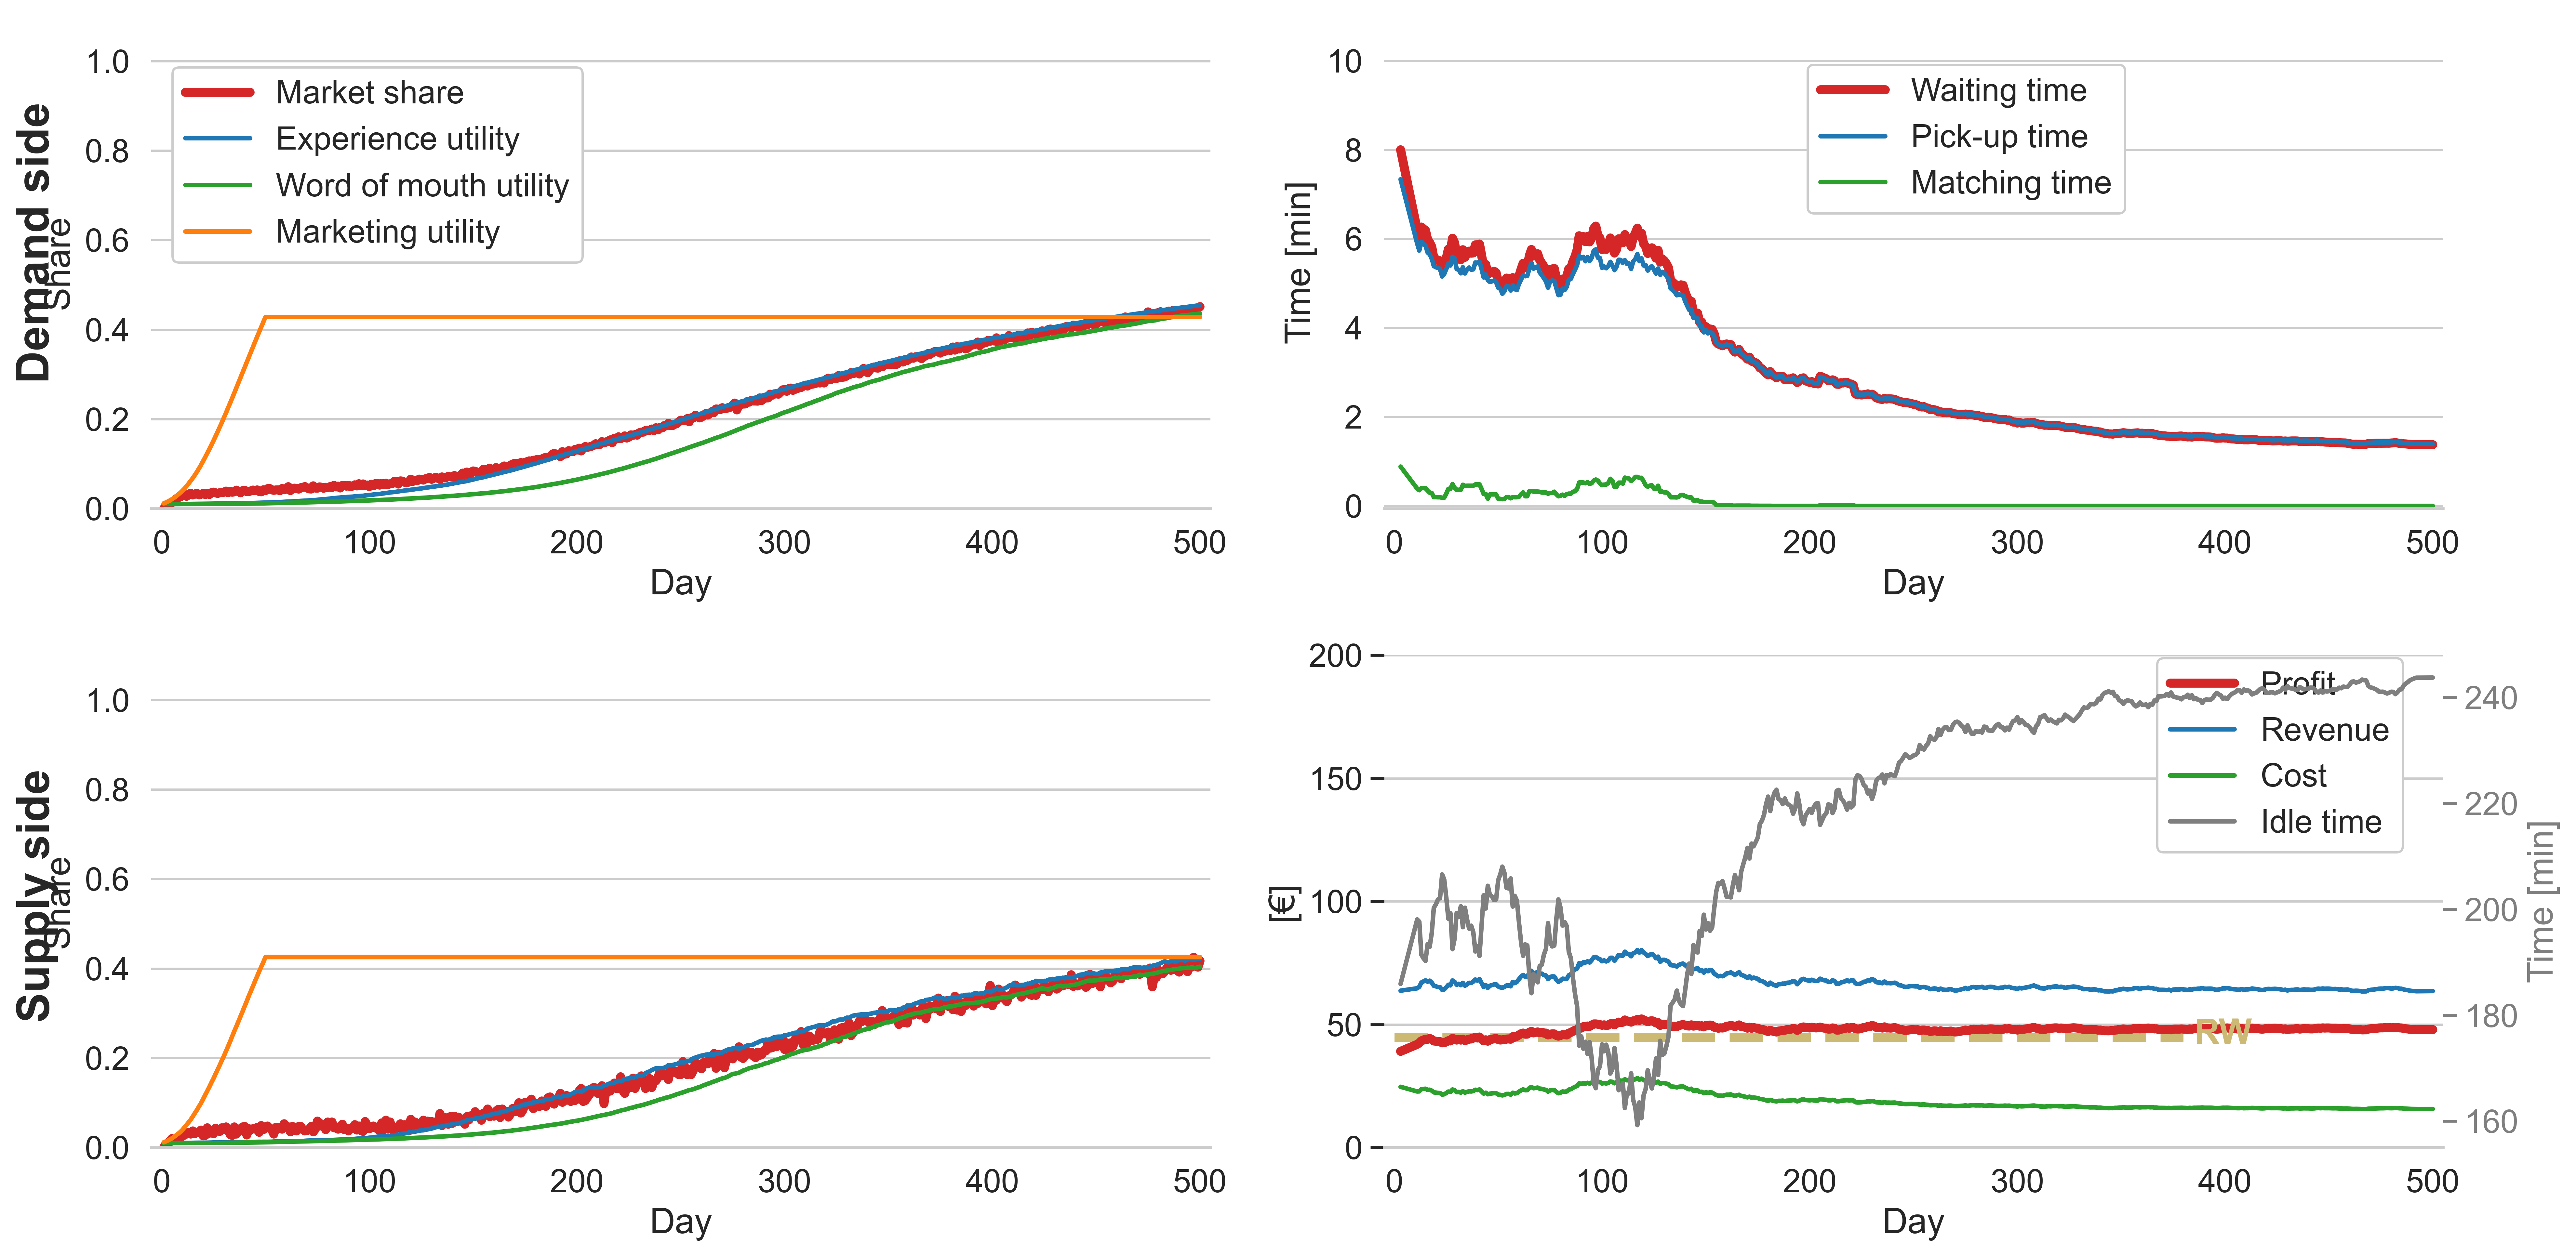

In [66]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
d1 = pd.DataFrame()


for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
        d1['P_WOM_U'] = yw; d1['P_MARKETING_U'] = ym
        d1['P_EXPERIENCE_U'] = ye; d1['P_SHARE'] = yms
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        d1['V_WOM_U'] = yw; d1['V_MARKETING_U'] = ym
        d1['V_EXPERIENCE_U'] = ye; d1['V_SHARE'] = yms
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n][0])
   
    # ax[ax_n][0].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n][0].grid(axis='x')
    ax[ax_n][0].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,sim.params.nD+5))
    
# ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.02,0.5))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1][0].get_legend().set_visible(False)

#===============================================================================================

x = []; yw = []; yp = []; yi = []; ym = []; yr = []; yprof = []; yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())

yw = smooth(yw); ym = smooth(ym); yp = smooth(yp); yi = smooth(yi)
yr = smooth(yr); yprof = smooth(yprof); yc = smooth(yc)

d2 = pd.DataFrame()
d2['yw'] = yw; d2['ym'] = ym; d2['yp'] = yp; d2['yi'] = yi
d2['yr'] = yr; d2['yprof'] = yprof; d2['yc'] = yc

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1][1])#, marker='o')ax.twinx()
ax11 = ax[1][1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1][1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i][1].grid(axis='x')

# ax[0][1].vlines([100], 0, 11, linestyles='dashed', colors='black')
# ax[1][1].vlines([100], 0, 110, linestyles='dashed', colors='black')
ax[1][1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1][1].annotate('RW', xy =(385,42), fontweight='bold', color='y')
  
    
ax[0][1].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,sim.params.nD+5)); ax[1][1].set(xlabel='Day', ylabel='[€]', ylim=(0,200),xlim=(-5,sim.params.nD+5))
ax[0][1].legend(loc=(0.4,0.6),framealpha=1)

ax[0][0].text(x=-70 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-70 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)
sns.despine(left=True)


plt.tight_layout()
# plt.savefig('Fig1x.png')

In [ ]:
================================================================================================

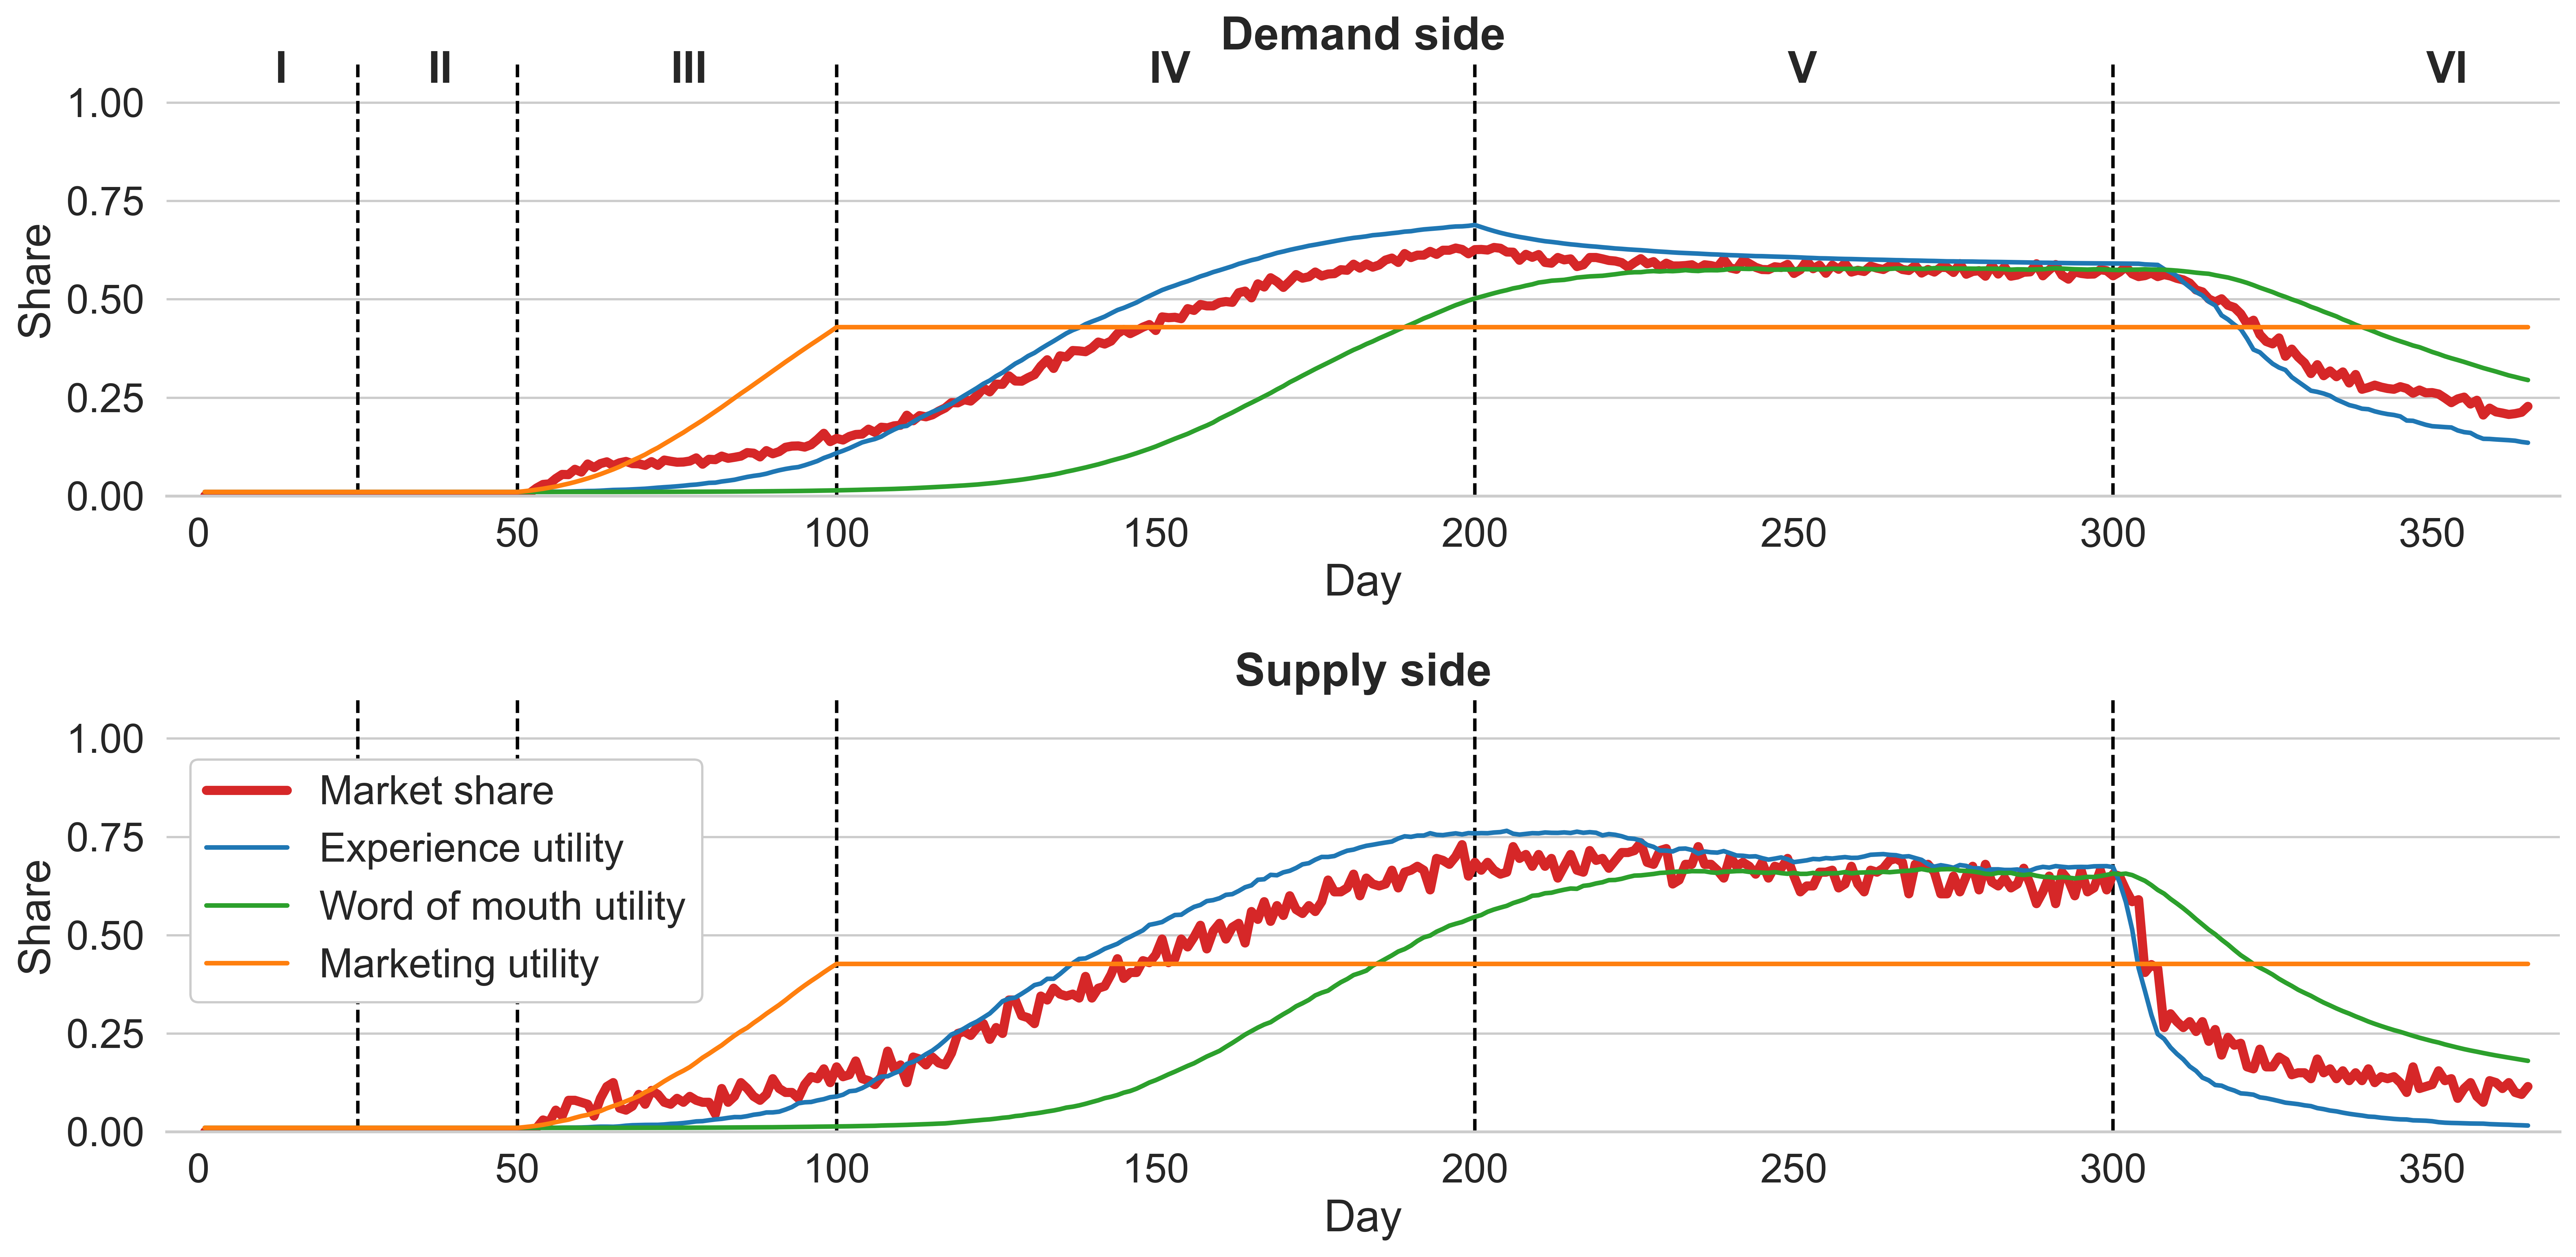

In [19]:
# nV=200, nP=2000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,370))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[1].legend(frameon=True,framealpha=1, loc=(0.01,0.3))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
plt.savefig('Fig1x.png')

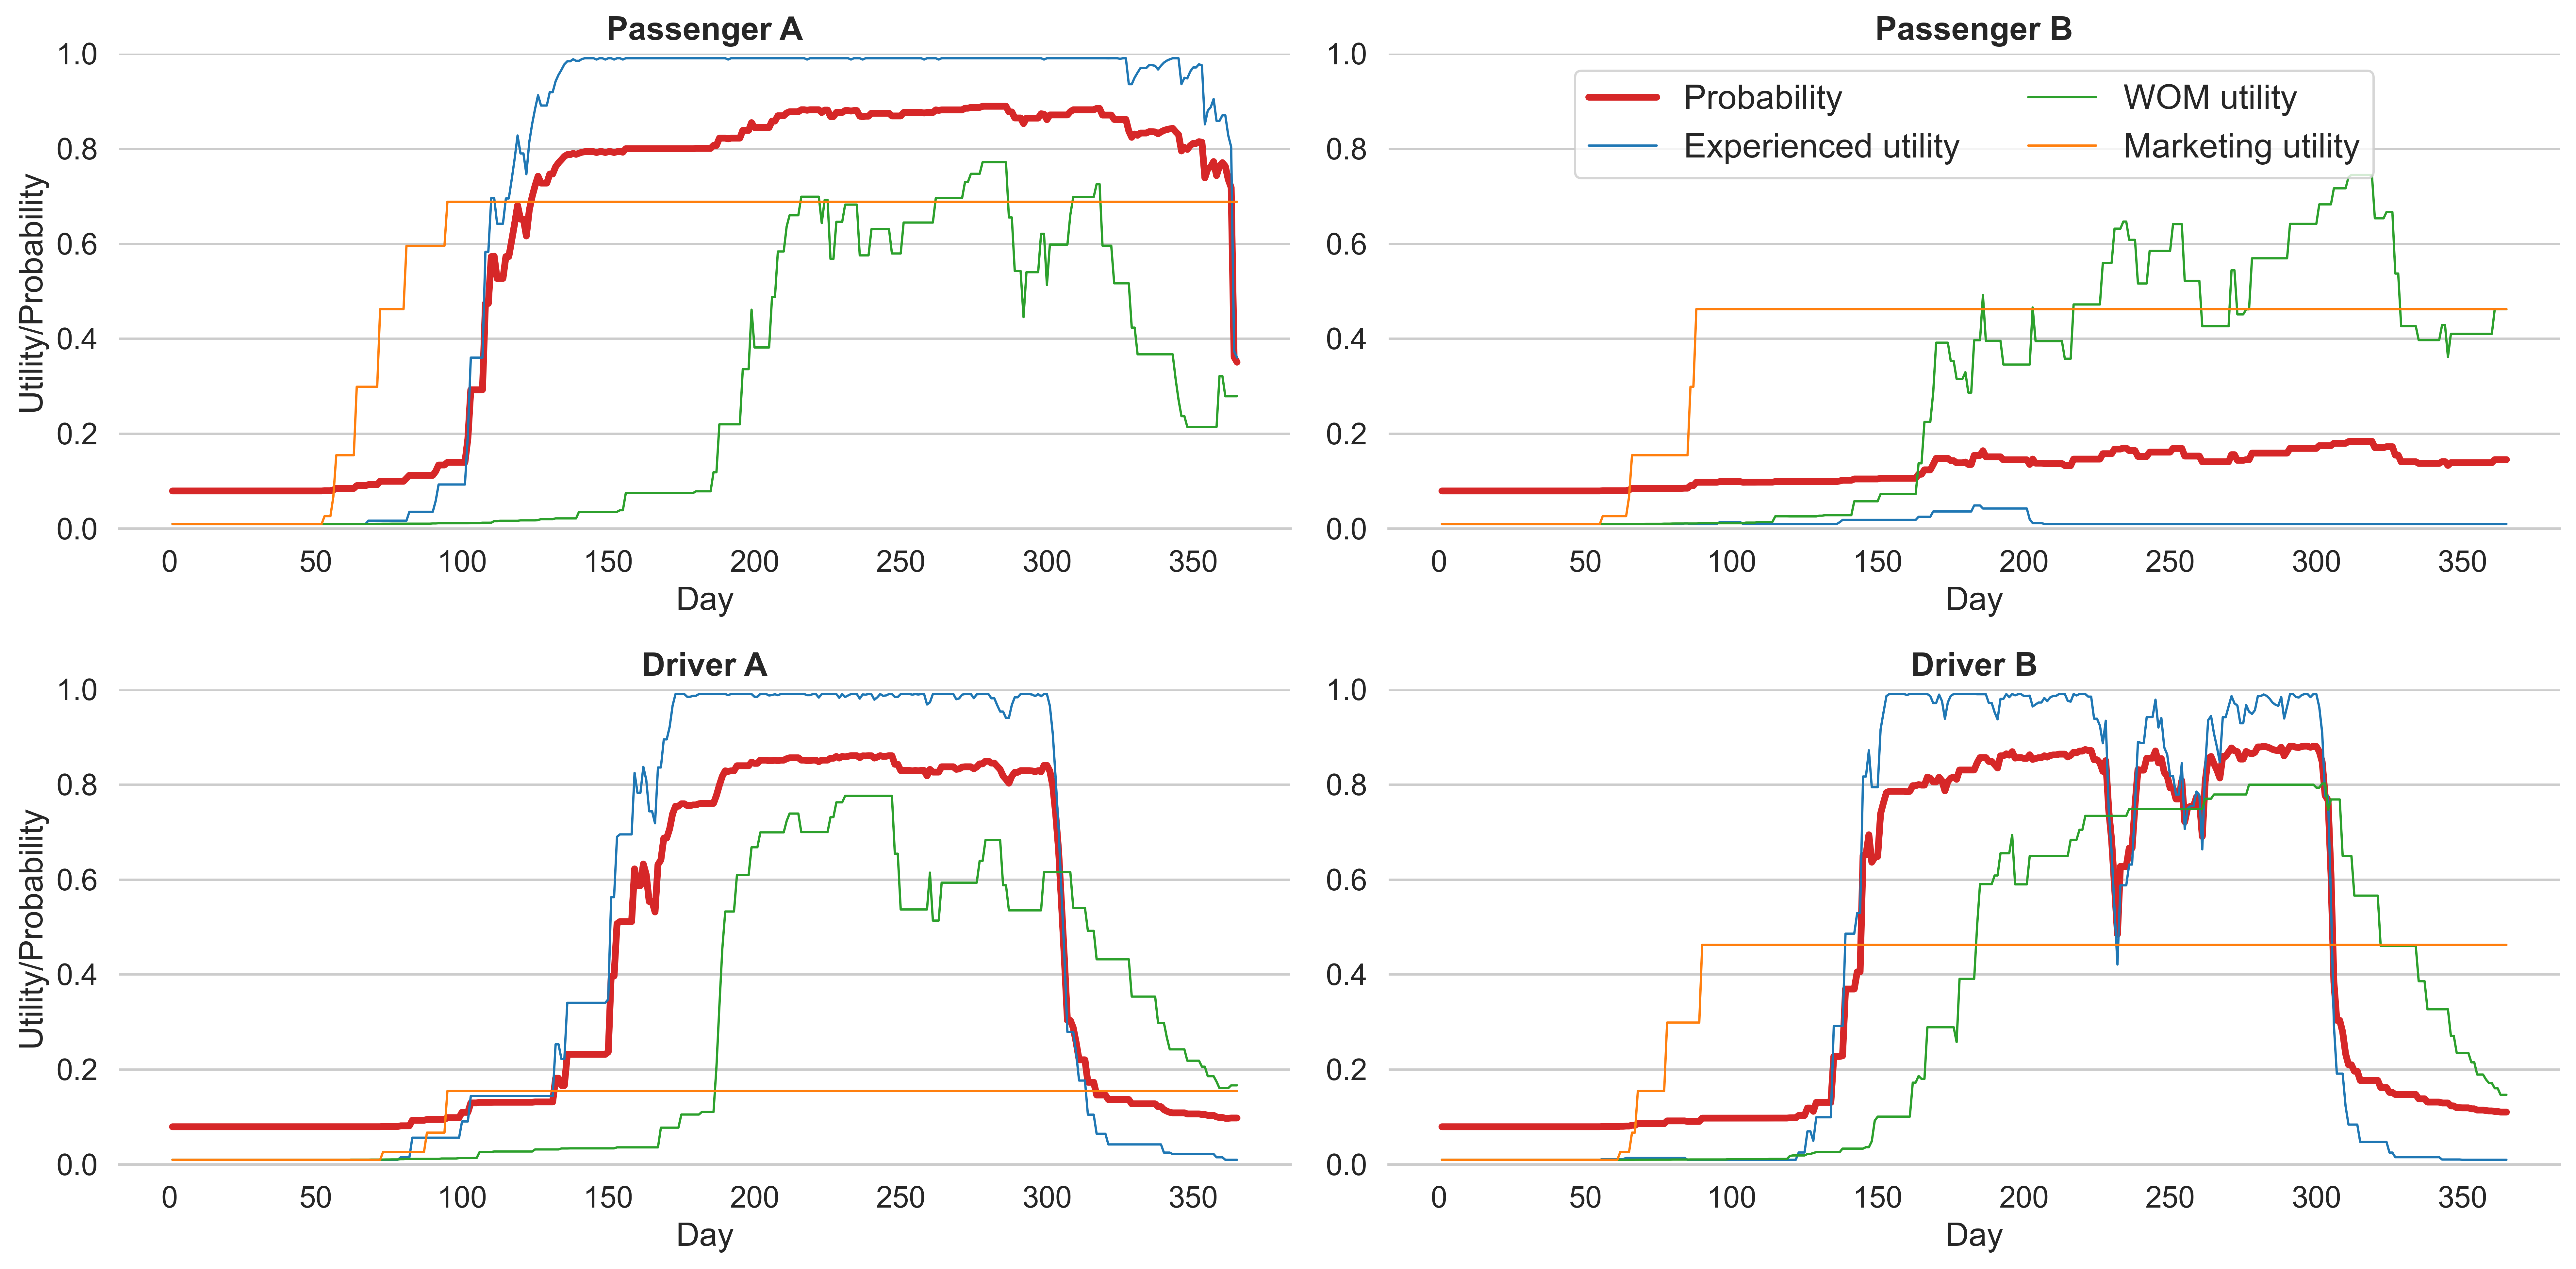

In [50]:
# individual assessment of agents

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.2)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
sns.despine(left=True)

ids = [2,3,3,6]
n = 0

for i in range(0,4):
    
    x = []; ye = []; ym = []; yw = []; yu = []; yp = []
    if i<2:
        pax_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].pax_exp.loc[pax_id].EXPERIENCE_U)
            ym.append(sim.res[d].pax_exp.loc[pax_id].MARKETING_U)
            yw.append(sim.res[d].pax_exp.loc[pax_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))
    else:
        veh_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].veh_exp.loc[veh_id].EXPERIENCE_U)
            ym.append(sim.res[d].veh_exp.loc[veh_id].MARKETING_U)
            yw.append(sim.res[d].veh_exp.loc[veh_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))

    if i<2:
        x = [i for i in range(1,len(ye)+1)]
        sns.lineplot(x=x, y=yp, label = 'Probability', color='C3', linewidth=3, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=ye, label = 'Experienced utility', color='C0', lw=1, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=yw, label = 'WOM utility', color='C2',lw=1, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=ym, label = 'Marketing utility', color='C1',lw=1, ax=ax[0][n])#, marker='o')
        # sns.lineplot(x=x, y=yu, label = 'TOTAL_U', ax=ax[n])#, marker='o')
        ax[0][n].set(xlabel='Day', ylim=(0,1))
        ax[0][n].grid(axis='x')
    else:
        x = [i for i in range(1,len(ye)+1)]
        sns.lineplot(x=x, y=yp, label = 'Probability', color='C3', linewidth=3, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=ye, label = 'Experienced utility', color='C0', lw=1, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=yw, label = 'WOM utility', color='C2',lw=1, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=ym, label = 'Marketing utility', color='C1',lw=1, ax=ax[1][n-2])#, marker='o')
        # sns.lineplot(x=x, y=yu, label = 'TOTAL_U', ax=ax[n])#, marker='o')
        ax[1][n-2].set(xlabel='Day', ylim=(0,1))
        ax[1][n-2].grid(axis='x')
        
    n += 1
    
ax[0][1].legend(loc='upper center', frameon=True, ncol=2, fontsize=15)
ax[0][0].set(ylabel='Utility/Probability');ax[1][0].set(ylabel='Utility/Probability')
ax[0][0].get_legend().set_visible(False);ax[1][0].get_legend().set_visible(False);ax[1][1].get_legend().set_visible(False)
ax[0][0].set_title('Passenger A',fontweight='bold');ax[0][1].set_title('Passenger B',fontweight='bold');ax[1][0].set_title('Driver A',fontweight='bold');ax[1][1].set_title('Driver B',fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig2.png')